In [43]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt

from algebra.cliffordalgebra import CliffordAlgebra
from modules.conv.kernel import CliffordSteerableKernel
from modules.conv.convolution import CliffordSteerableConv
from models.resnets import CSResNet

key_id = 42

# Visualizing kernels

### Euclidean space $\mathbb{R}^{(2,0)}$

Let us demonstrate an example with (p,q) = (2,0), which is equivalent to familiar two-dimensional Euclidean vector space.

The signature corresponds to the metric matrix with ones along the diagonal, i.e. diag((1,1)). It is the diagonal elements of the metrix matrix that we use to initialize the key object - Clifford algebra - which containts all necessary basic attributes and methods for our case (e.g. geometric product).

In [44]:
algebra = CliffordAlgebra((1,1))

Let us now visualize a single Clifford-steerable kernel with c_in = c_out = 1. 

Since implicit kernels allow for arbitrary discretization, we use relatively high resolution. In practice, however, it will be much lower, e.g. 3x3, or 7x7x7.

In [45]:
resolution = 128

config = dict(
    algebra = algebra,
    kernel_size = resolution,
    c_in = 1,
    c_out = 1,
    num_layers = 4,
    hidden_dim = 12, 
    bias_dims = (0,),
    product_paths_sum = algebra.geometric_product_paths.sum().item()
)

In [46]:
kernel = CliffordSteerableKernel(**config)

# Initialize parameters
params = kernel.init(jax.random.PRNGKey(key_id))

# Compute the kernel given the parameters
k = kernel.apply(params)

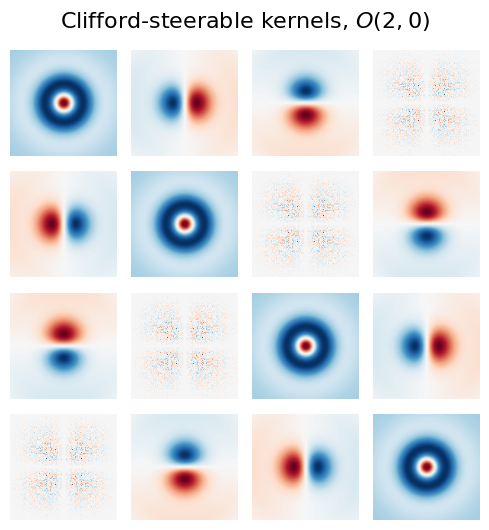

In [47]:
fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(k[i, j].T, cmap='RdBu')
        ax[i, j].axis('off')
                
fig.tight_layout()

fig.suptitle('Clifford-steerable kernels, $O(2,0)$', fontsize=16, y=1.05)
plt.show()

Note that pseudoscalar kernel is not exactly zero, but it has negligible magnitute of order 1e-9.

### Minkowski space $\mathbb{R}^{(1,1)}$

In this case, there are negative elements along the diagonal of the metric tensor. 
Time-like dimensions are represented by positive elements in the metric tensor and space-like dimensions are represented by negative elements.

In [48]:
algebra = CliffordAlgebra((1,-1))

In [49]:
resolution = 128

config = dict(
    algebra = algebra,
    kernel_size = resolution,
    c_in = 1,
    c_out = 1,
    num_layers = 4,
    hidden_dim = 12, 
    bias_dims = (0,),
    product_paths_sum = algebra.geometric_product_paths.sum().item()
)

In [50]:
kernel = CliffordSteerableKernel(**config)

# Initialize parameters
params = kernel.init(jax.random.PRNGKey(key_id))

# Compute the kernel given the parameters
k = kernel.apply(params)

We now plot the kernel, y-axis corresponds to time, x-axis to space

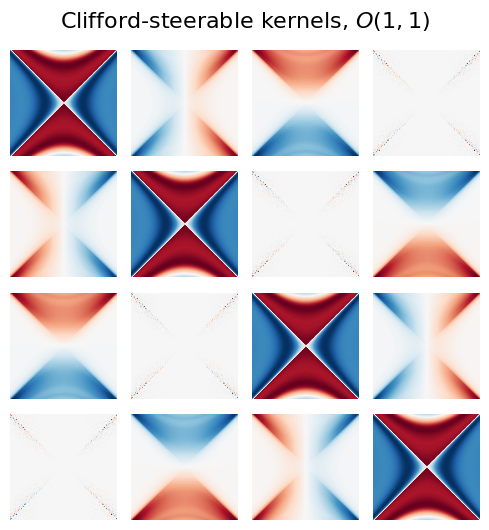

In [51]:
fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(k[i, j].T, cmap='RdBu')
        ax[i, j].axis('off')
                
fig.tight_layout()

fig.suptitle('Clifford-steerable kernels, $O(1,1)$', fontsize=16, y=1.05)
plt.show()

# Applying convolution

Let us now initialize a convolutional layer and apply it to an input image.

In [111]:
algebra = CliffordAlgebra((-1,1))

config = dict(
    algebra = algebra,
    c_in = 1,
    c_out = 8,
    kernel_size = 7,
    padding = True,
    num_layers = 4,
    hidden_dim = 12, 
    bias_dims = (0,),
    product_paths_sum = algebra.geometric_product_paths.sum().item()
)

In [112]:
csconv = CliffordSteerableConv(**config)

# random input for initialization
mv = jax.random.normal(jax.random.PRNGKey(key_id), (16,1,64,64,algebra.n_blades))
params = csconv.init(jax.random.PRNGKey(key_id), mv)

Let us define our input multivector fields as follows:
- scalar: $sin(x) + cos(y)$ 
- vector: $\left[sin(x) sin(y), cos(x) cos(y)^2\right]$
- pseudoscalar: $cos(x) - sin(y)$


In [113]:
# Define the grid size
grid_size = 64

# Initialize the grid
x, y = jnp.meshgrid(jnp.linspace(0, 2 * jnp.pi, grid_size), jnp.linspace(0, 2 * jnp.pi, grid_size))

In [114]:
scalar = jnp.sin(x) + jnp.cos(y)
vector_x = jnp.sin(x) * jnp.sin(y)
vector_y = jnp.cos(x) * jnp.cos(y)**2
bivector = jnp.cos(x) - jnp.sin(y)

mv_field = jnp.stack([scalar, vector_x, vector_y, bivector], axis=-1)
mv_field = jnp.expand_dims(mv_field, axis=[0, 1])

In [115]:
# Apply the convolution
out = csconv.apply(params, mv_field)

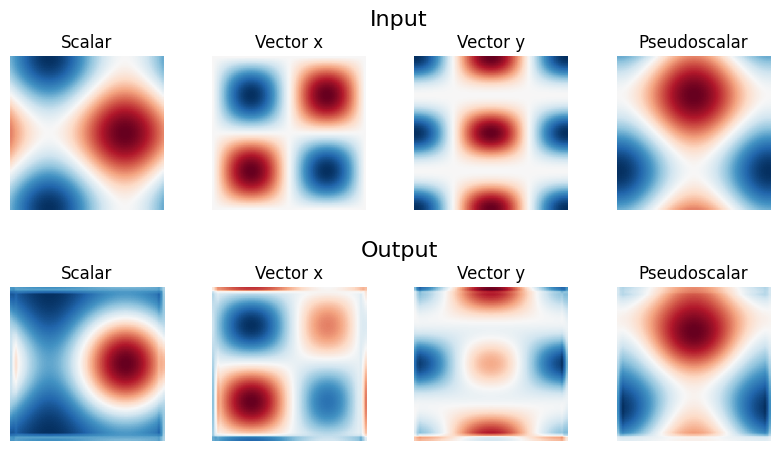

In [120]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ['Scalar', 'Vector x', 'Vector y', 'Pseudoscalar']
channel = 2

for i in range(4):
    ax[0,i].imshow(mv_field[0, channel, :, :, i], cmap='RdBu')
    ax[0,i].axis('off')
    ax[0,i].set_title(component_names[i])
    
for i in range(4):
    ax[1,i].imshow(out[0, channel, :, :, i], cmap='RdBu')
    ax[1,i].axis('off')
    ax[1,i].set_title(component_names[i])
    
# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(-0.1, 1.2, 'Input', ha='center', fontsize=16, transform=ax[0,2].transAxes)
plt.text(-0.1, 1.2, 'Output', ha='center', fontsize=16, transform=ax[1,2].transAxes)
plt.show()